## STEP 1 : 데이터 및 라이브러리 불러오기

In [70]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성 - 종가만 사용
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 전처리 수행

In [72]:
# 결측치 보간 및 제거
ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [73]:
# 로그 변환
ts_log = np.log(ts)
ts_log.head()

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해
- Residual 안정성 확인

In [74]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [75]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

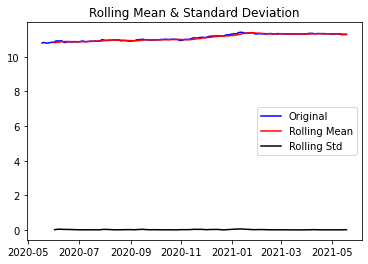

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


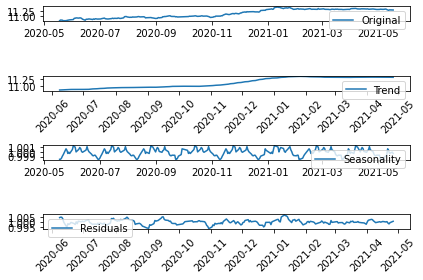

In [76]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()

In [77]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

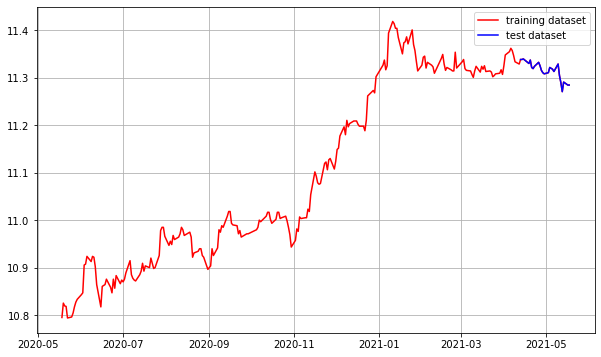

In [78]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보고 p, q 구하기
- 차분 안정성 확인 후 d 구하기

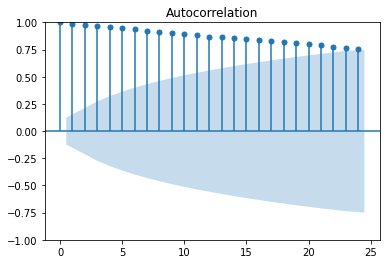

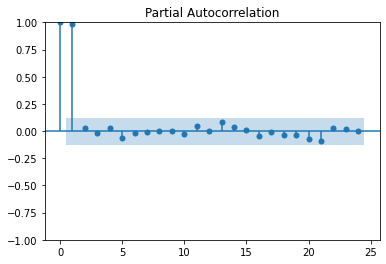

In [79]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log, method='ywm')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


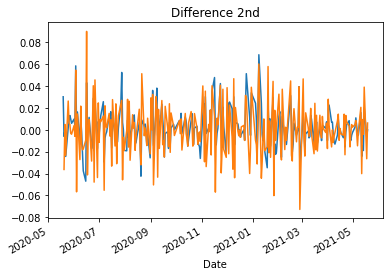

In [80]:
## 차분 안정성 구해서 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [81]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 29 Feb 2024   AIC                          -1156.722
Time:                        08:52:35   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


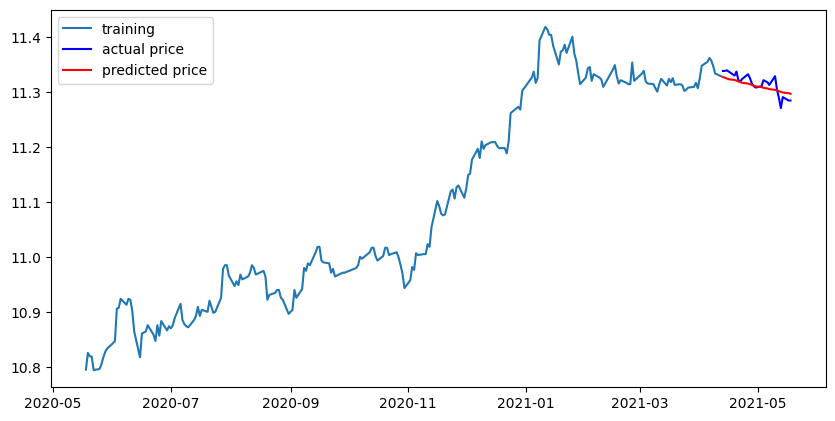

In [82]:
# Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측 결과

# Plot
plt.figure(figsize = (10, 5), dpi=100)

plt.plot(train_data, label="training")
plt.plot(test_data, c='b', label="actual price")
plt.plot(fc_series, c='r', label= 'predicted price')
plt.legend()
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7 : 다른 주식 종목 예측해 보기

### 1) Unity

In [84]:
unity = pd.read_csv("U.csv", index_col = "Date", parse_dates=True)
ts = unity["Close"]

ts.head()

Date
2023-02-28    30.440001
2023-03-01    29.709999
2023-03-02    29.420000
2023-03-03    30.870001
2023-03-06    30.250000
Name: Close, dtype: float64

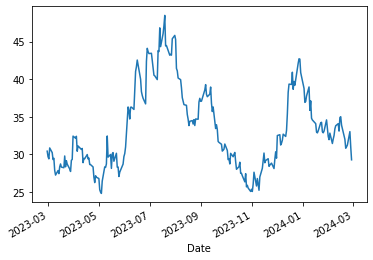

In [85]:
ts.plot(kind="line");

In [86]:
ts = pd.DataFrame(ts)

ts["year"] = ts.index.year
ts["month"] = ts.index.month
ts["day"] = ts.index.day

### 7-1. 데이터 시각화

In [87]:
import seaborn as sns

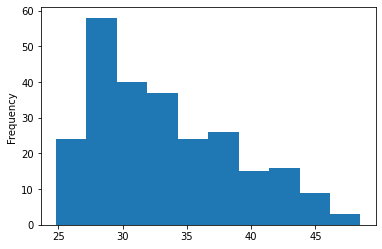

In [88]:
ts["Close"].plot(kind="hist");

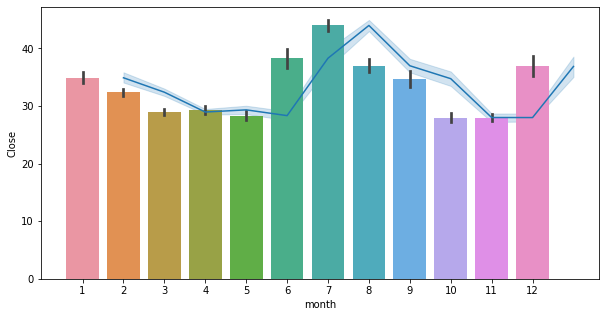

In [89]:
plt.figure(figsize=(10,5))
sns.barplot(data=ts, x='month', y = 'Close')
sns.lineplot(data=ts, x="month", y="Close");

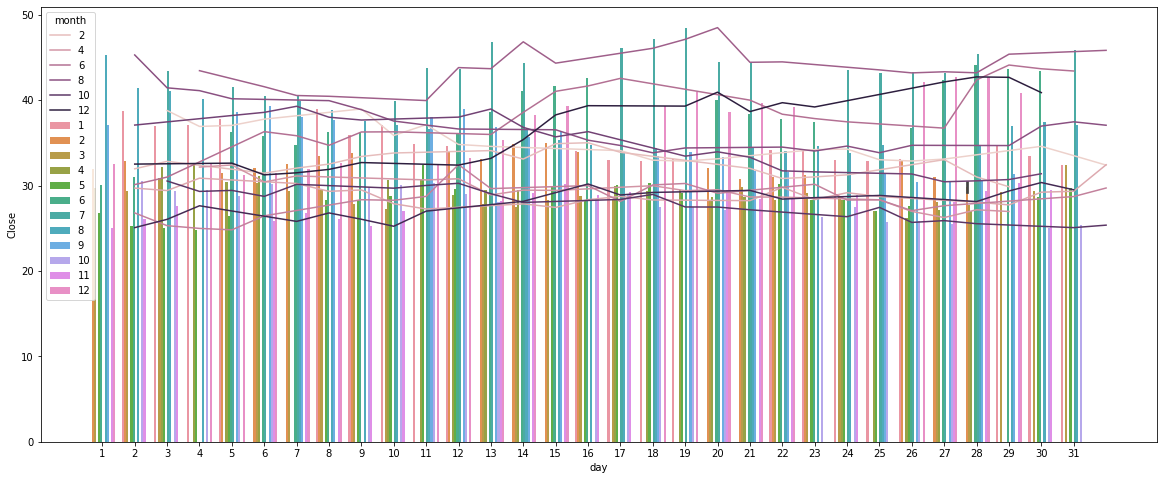

In [90]:
plt.figure(figsize=(20,8))
sns.barplot(data=ts, x='day', y = 'Close', hue = 'month')
sns.lineplot(data=ts, x="day", y="Close", hue = "month");

### 7-2. 데이터 전처리

In [91]:
ts.drop(["year", "month", "day"], axis=1, inplace=True)

In [92]:
# 결측치 보간
ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log = np.log(ts)
ts_log.head()

,Close
Date,
2023-02-28,3.415758
2023-03-01,3.391484
2023-03-02,3.381675
2023-03-03,3.429785
2023-03-06,3.409496


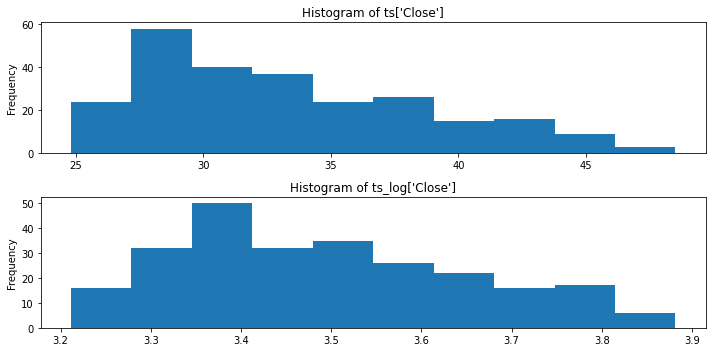

In [93]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# 첫 번째 서브플롯에 히스토그램 그리기
ts["Close"].plot(kind="hist", ax=ax[0])
ax[0].set_title("Histogram of ts['Close']")

ts_log["Close"].plot(kind="hist", ax=ax[1])
ax[1].set_title("Histogram of ts_log['Close']")

plt.tight_layout()
plt.show()

### 7-3. 시계열 안정성 분석

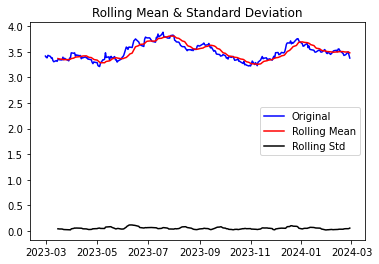

Results of Dickey-Fuller Test:
Test Statistic                  -1.901197
p-value                          0.331498
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


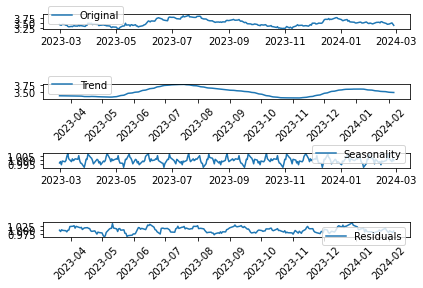

In [94]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.tight_layout()

In [95]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.794944e+00
p-value                        4.776067e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


### 7-4. 학습, 테스트 데이터셋 생성

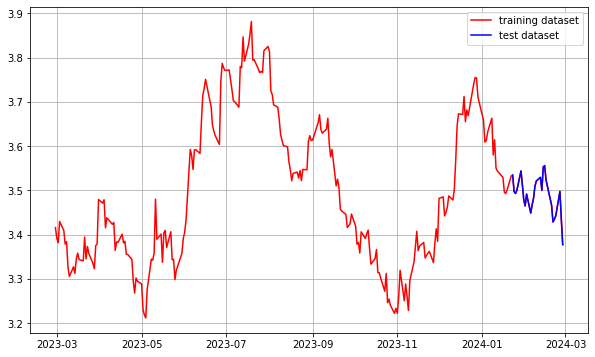

In [96]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

### 7-5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보고 p, q 구하기
- 차분 안정성 확인 후 d 구하기

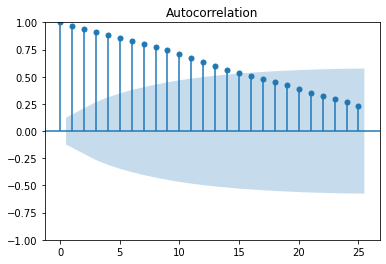

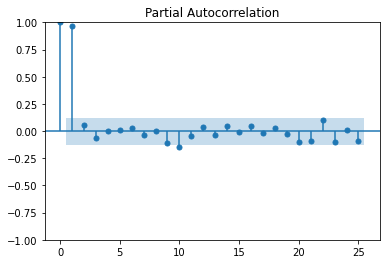

In [97]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log, method='ywm')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.666443e+01
p-value                        1.564099e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.134395e+01
p-value                        1.038127e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


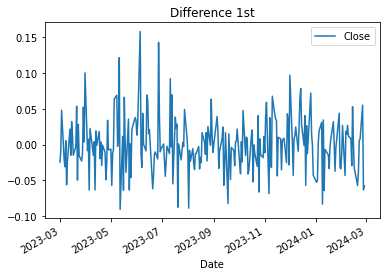

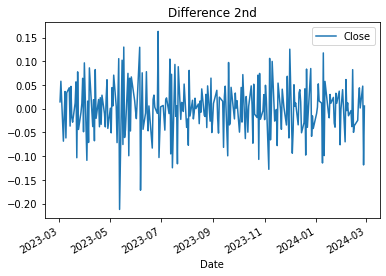

In [98]:
## 차분 안정성 구해서 d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 7-6. ARIMA 모델 훈련과 테스트

In [99]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 412.370
Date:                Thu, 29 Feb 2024   AIC                           -814.740
Time:                        08:52:43   BIC                           -797.637
Sample:                             0   HQIC                          -807.838
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4894      0.093     37.412      0.000       3.307       3.672
ar.L1          0.1787      0.327      0.546      0.585      -0.462       0.820
ar.L2          0.7698      0.320      2.402      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


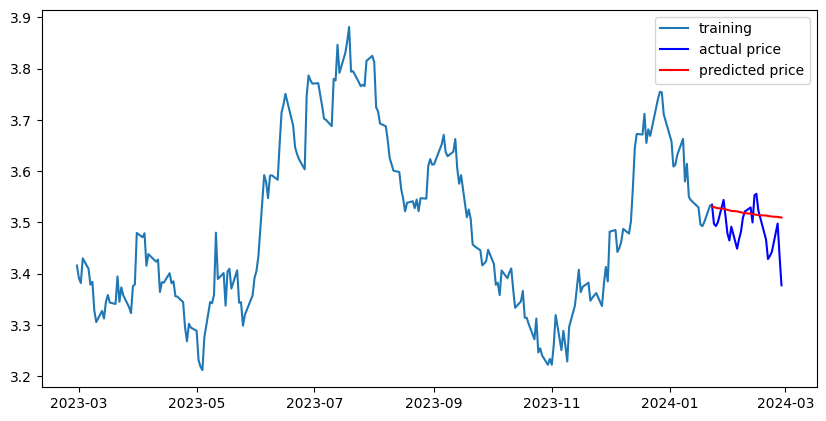

In [100]:
# Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측 결과

# Plot
plt.figure(figsize = (10, 5), dpi=100)

plt.plot(train_data, label="training")
plt.plot(test_data, c='b', label="actual price")
plt.plot(fc_series, c='r', label= 'predicted price')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# fc와 test_data의 형태가 다른 경우
mape = np.mean(np.abs(np.exp(np.array(fc)) - np.exp(np.array(test_data))) / np.abs(np.exp(np.array(test_data))))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  2.6957016392183593
MAE:  1.3345205840035228
RMSE:  1.6418592020080038
MAPE: 4.25%


### 2) TESAL

In [102]:
tesla = pd.read_csv("TSLA.csv", index_col = "Date", parse_dates=True)
ts = pd.DataFrame(tesla["Close"])
ts.head()

,Close
Date,
2023-02-28,205.710007
2023-03-01,202.770004
2023-03-02,190.899994
2023-03-03,197.789993
2023-03-06,193.809998


In [103]:
# 결측치 보간
ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log = np.log(ts)
ts_log.head()

,Close
Date,
2023-02-28,5.326467
2023-03-01,5.312072
2023-03-02,5.251750
2023-03-03,5.287206
2023-03-06,5.266878


- p-value가 

In [104]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.794944e+00
p-value                        4.776067e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


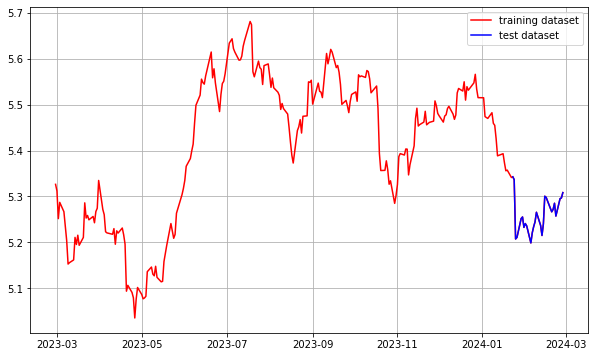

In [105]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

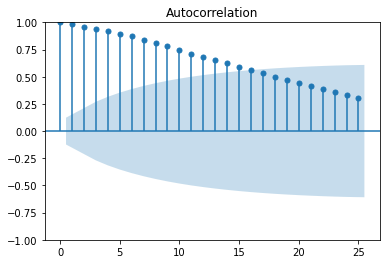

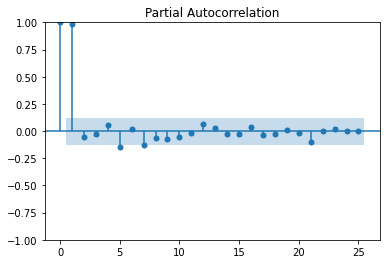

In [106]:
plot_acf(ts_log)
plot_pacf(ts_log, method='ywm')
plt.show()

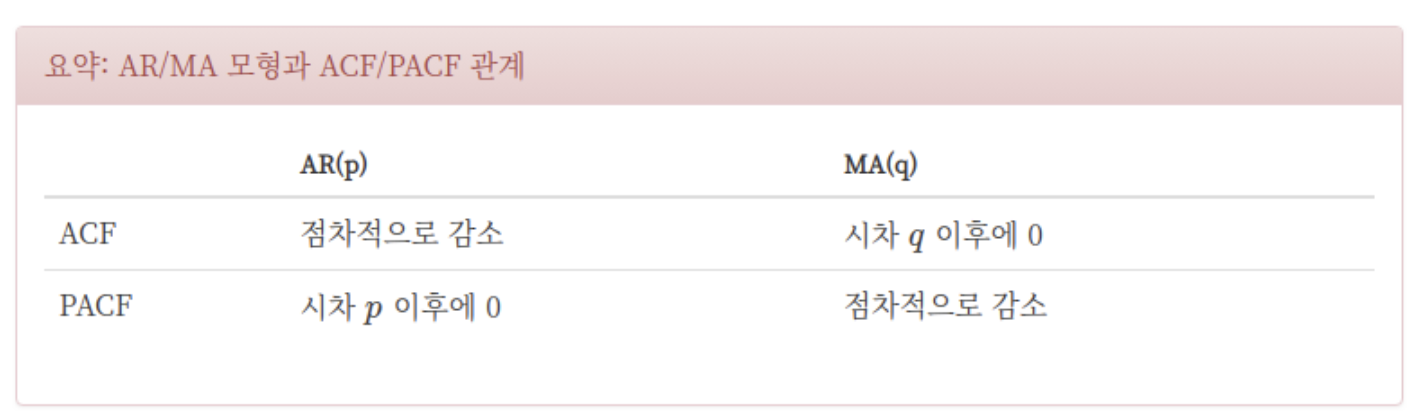

- ARIMA 모델에서 p, d, q를 설정해주어야 하는데, p + q < 2, p * q = 0의 수식을 따르도록 설정한다고 합니다.
- 위의 표에 기반하여 ACF가 점차적으로 감소하고 PACF가 시차 p 이후에 거의 0으로 수렴하는 것으로 보아 p=2, q=0으로 설정합니다.

Results of Dickey-Fuller Test:
Test Statistic                  -5.613714
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.709373e+00
p-value                        1.021292e-16
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


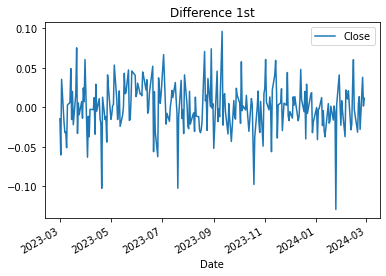

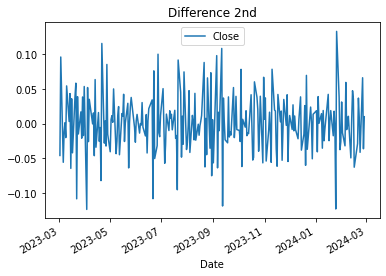

In [107]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분의 모습이 더욱 안정화 되어 있는 것으로 보아 d=2로 확인합니다.

In [108]:
from statsmodels.tsa.arima.model import ARIMA

order = (2, 2, 0)

model = ARIMA(train_data, order=order)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 433.593
Date:                Thu, 29 Feb 2024   AIC                           -861.186
Time:                        08:52:45   BIC                           -850.951
Sample:                             0   HQIC                          -857.054
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6254      0.063     -9.991      0.000      -0.748      -0.503
ar.L2         -0.2352      0.068     -3.458      0.001      -0.369      -0.102
sigma2         0.0012      0.000     11.782      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


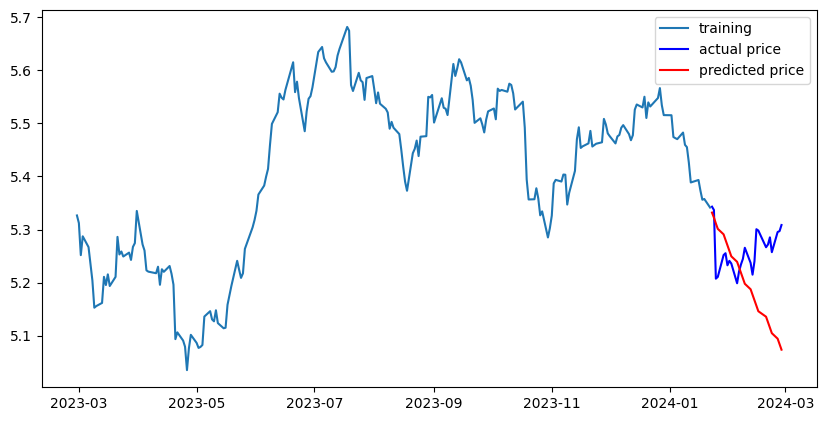

In [109]:
# Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측 결과

# Plot
plt.figure(figsize = (10, 5), dpi=100)

plt.plot(train_data, label="training")
plt.plot(test_data, c='b', label="actual price")
plt.plot(fc_series, c='r', label= 'predicted price')
plt.legend()
plt.show()

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# fc와 test_data의 형태가 다른 경우
mape = np.mean(np.abs(np.exp(np.array(fc)) - np.exp(np.array(test_data))) / np.abs(np.exp(np.array(test_data))))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  403.476094679693
MAE:  15.739315478350242
RMSE:  20.086714382389495
MAPE: 8.04%


### TESAL 데이터를 바탕으로 비선형 모델링 진행하기

- 위의 ARIMA 모델은 주로 선형적으로 예측하는 모습을 볼 수 있었습니다.
- 따라서 비선형적으로 모델링을 할 수 있도록 개선된 SARIMA 모델을 사용해봅니다.

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 0)
seasonal_order = (1, 1, 1, 12)

model_SA = SARIMAX(train_data, order=order, seasonal_order = seasonal_order)
fitted_m = model_SA.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


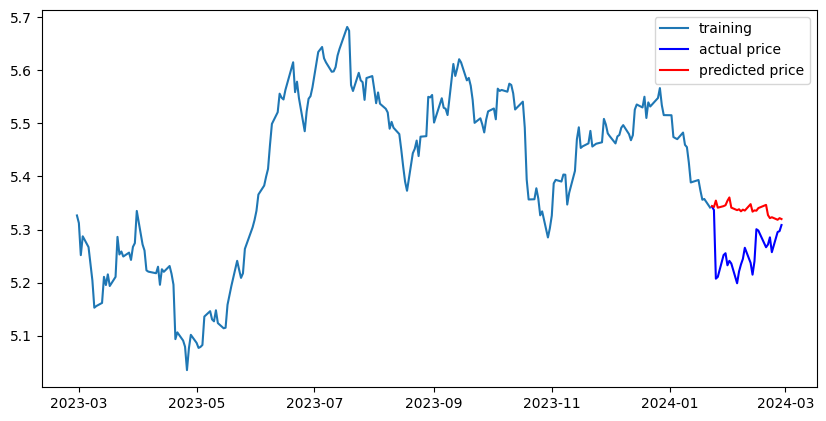

In [112]:
# Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측 결과

# Plot
plt.figure(figsize = (10, 5), dpi=100)

plt.plot(train_data, label="training")
plt.plot(test_data, c='b', label="actual price")
plt.plot(fc_series, c='r', label= 'predicted price')
plt.legend()
plt.show()

In [113]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# fc와 test_data의 형태가 다른 경우
mape = np.mean(np.abs(np.exp(np.array(fc)) - np.exp(np.array(test_data))) / np.abs(np.exp(np.array(test_data))))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  310.8178514782904
MAE:  15.483137105040678
RMSE:  17.63002698461606
MAPE: 8.28%


- SARIMA 모델을 사용했을 때, 지표에 따라 어느정도 더 나은 성능을 보여준 것을 알 수 있었습니다.
- 이어서 시계열 데이터에서 주로 사용되는 LSTM 모델을 기반으로 확인해보고자 합니다.

In [114]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 전처리
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# 시퀀스 데이터 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 입력 시퀀스 길이
X, y = create_sequences(ts_scaled, seq_length)

# 데이터를 학습 세트와 테스트 세트로 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 5ms/step - loss: 0.1411
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 11/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 12/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 13/100
6/6 [==============================] - 0s 5ms/st

Test Loss: 0.002415982773527503


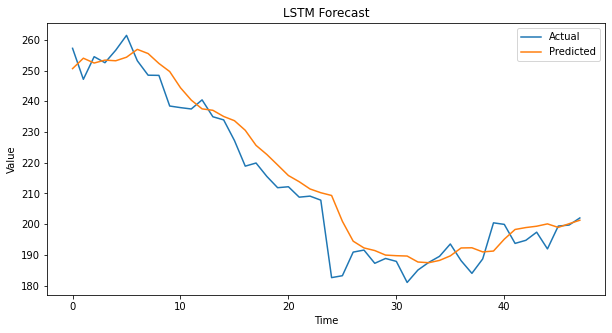

In [115]:
# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

# 예측
y_pred = model.predict(X_test)

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [116]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [117]:
from sklearn.metrics import mean_squared_error

# 모델의 예측 결과 생성
y_pred = model.predict(X_test)

# 예측 결과를 역변환하여 원래 스케일로 되돌리기
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# MSE 계산
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('Mean Squared Error (MSE):', mse)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Absolute Error (MSE):', mae)

Mean Squared Error (MSE): 47.07631811708719
Mean Absolute Error (MSE): 5.02938745452881


In [118]:
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
print('MAPE: {:.2f}%'.format(mape))

MAPE: 2.42%


**ARIMA, SARIMA**
- 주식 데이터는 주로 비선형적으로 주가가 변동되기 때문에, 이를 고려하기 위해선 비선형적 모델을 활용해야 한다.
- ARIMA의 경우, 하이퍼 파라미터가 미치는 주요 영향이 매우 크기 때문에, 각 p, d, q에 맞는 값을 채택하기 위해 ACF, PACF, 차분 그래프를 시각화하여 각 값의 적당한 수치를 적용해줘야 한다.
- SARIMA의 경우도 동일하다고 판단 했다. SARIMA의 경우 튜닝해줘야 하는 하이퍼파라미터가 더욱 많기 때문에, 이를 고려하여 더욱 적절한 값을 넣어준다면 비선형 모델이기에 선형 모델인ARIMA 보다 좋은 성능을 보여줄 것이라고 생각한다.

**LSTM**
- 더불어 딥러닝에서 주로 시퀀스 데이터에 활용되는 LSTM의 경우, 다른 모델을 크게 뛰어넘는 성능을 보여주었다.
- 이는 딥러닝 모델 자체적으로 비선형적으로 작동하기 때문이라고 판단하였다.
- LSTM의 경우도 모델의 구조를 조금 수정해준다면 더욱 높은 정확도를 불러올 수 있을 것이라고 생각된다.